# **Анализ отзывов о British Airways**

In [179]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

rcParams['figure.figsize']=12,6
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Сбор данных

Данные изначально нужно собрать, поэтому код ниже собирает все отзывы с данного сайта

In [ ]:
base_url = "https://www.airlinequality.com/airline-reviews/british-airways"
pages = 100
page_size = 37

reviews = []

for i in range(1, pages + 1):

    print(f"Scraping page {i}")

    url = f"{base_url}/page/{i}/?sortby=post_date%3ADesc&pagesize={page_size}"

    response = requests.get(url)

    content = response.content
    parsed_content = BeautifulSoup(content, 'html.parser')
    for para in parsed_content.find_all("div", {"class": "text_content"}):
        reviews.append(para.get_text())

    print(f"   ---> {len(reviews)} total reviews")

In [ ]:
df = pd.DataFrame(reviews, columns=['reviews'])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Сохраним данные, чтобы сэкономить время в случае перезапуска среды

In [ ]:
df.to_csv("/content/BA_rvws.csv", index=False)

# Подготовка данных

Загрузим и очистим данные

In [180]:
df = pd.read_csv('/content/BA_rvws.csv')

In [181]:
df.head()

,reviews
0,Not Verified | I booked Premium Economy from I...
1,✅ Trip Verified | A simple story with an unfor...
2,✅ Trip Verified | Flight was delayed due to t...
3,Not Verified | Fast and friendly check in (to...
4,✅ Trip Verified | I don't understand why Brit...


In [182]:
reviews = []
for i in range(len(df.reviews)):
  if '|' in df.reviews.iloc[i]:
    reviews.append(df.reviews.iloc[i][df.reviews.iloc[i].index('|')+1:].strip())
  else:
    reviews.append(df.reviews.iloc[i].strip())

In [183]:
df["reviews"] = reviews
df.head()

,reviews
0,I booked Premium Economy from INV to LAX (via ...
1,A simple story with an unfortunate outcome tha...
2,Flight was delayed due to the inbound flight a...
3,Fast and friendly check in (total contrast to ...
4,I don't understand why British Airways is clas...


In [184]:
df.shape

(3608, 1)

In [185]:
nltk.download('stopwords')
stop_words1 = stopwords.words('english')
# Эмпирически было выявлено, что данные слова значительно чаще других встречаются в отзывах
# Сами по себе они не несут никакой полезной информации
stop_words1.extend(['ba', 'flight', 'british', 'airway', "airline"])

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    stop_words = set(stop_words1)
    text = ' '.join(word for word in text.split() if word not in stop_words)
    lemmatizer = WordNetLemmatizer()
    text = ' '.join(lemmatizer.lemmatize(word) for word in text.split())
    return text

df['clean_text'] = df['reviews'].apply(clean_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Анализ отзывов

Выделять темы отзывов будем с помощью простого инстурмента - латентного размещения Дирихле

Выберем *n_topics=1*, чтобы получить общее представление об отзывах

In [186]:
import gensim
from gensim import corpora

tokenized_reviews = [gensim.utils.simple_preprocess(review) for review in df['clean_text']]

dictionary = corpora.Dictionary(tokenized_reviews)

bow_reviews = [dictionary.doc2bow(review) for review in tokenized_reviews]

lda_model = gensim.models.ldamodel.LdaModel(bow_reviews, id2word=dictionary, num_topics=1, random_state=42)

for topic in lda_model.print_topics():
    print(topic)

(0, '0.016*"seat" + 0.010*"service" + 0.008*"food" + 0.008*"time" + 0.008*"good" + 0.008*"crew" + 0.007*"airway" + 0.007*"cabin" + 0.006*"class" + 0.006*"london"')


Визуализируем результат, выбрав 20 самых популярных слов в отзывах

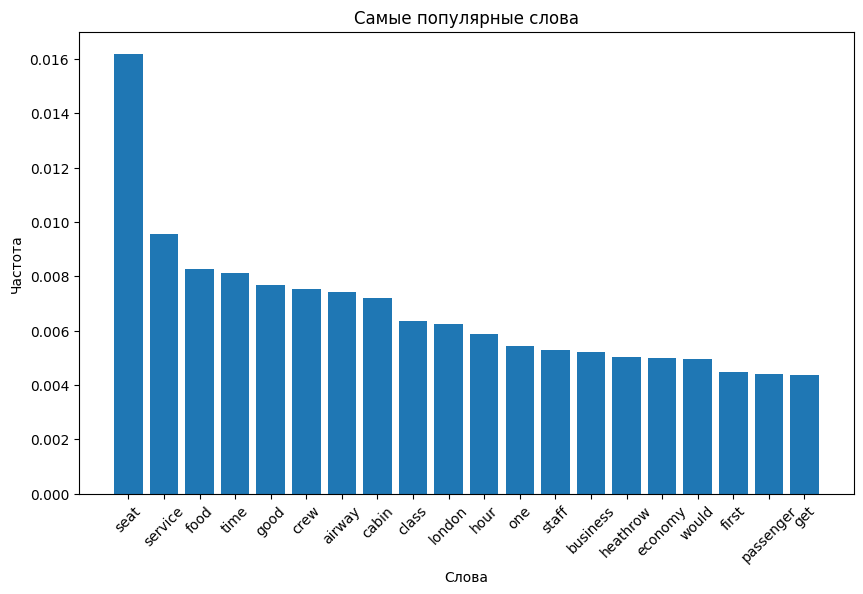

In [187]:
top_words = lda_model.show_topic(0, topn=20)

plt.figure(figsize=(10,6))
plt.bar([word[0] for word in top_words], [word[1] for word in top_words])
plt.title('Самые популярные слова')
plt.xlabel('Слова')
plt.ylabel("Частота")

plt.xticks(rotation=45)
plt.show()

Построим еще одну модель, но на этот раз выберем 10 топ-тем и 10 топ-слов для каждой из них и визуализируем их с помощью облаков из слов

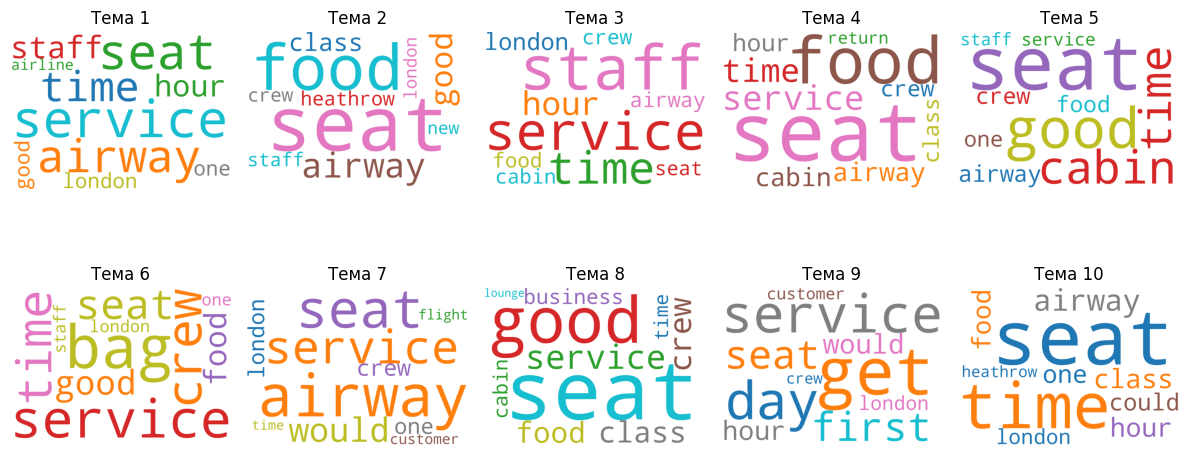

In [188]:
lda_model_10 = gensim.models.ldamodel.LdaModel(bow_reviews, id2word=dictionary, num_topics=10, random_state=42)

cloud = WordCloud(stopwords=stop_words1,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  )

topics = lda_model_10.show_topics(formatted=False)

fig, axes = plt.subplots(2,5, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Тема ' + str(1+i))
    plt.gca().axis('off')

plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

Исходя из диаграммы и облаков, видно, что преобладающие темы - это кресла, еда, команда авиакомпании и время. В большинстве тем преобладает слово *good*, что позволяет интерпретировать облако в хорошем и позитивном контексте

Также проведем еще сентиментный анализ отзывов - анализ настроений

In [190]:
from textblob import TextBlob

def get_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity

df['sentiment'] = df['clean_text'].apply(get_sentiment)

Настроение принимает диапозон значений от -1 до 1, где -1 - абсолютно негативный отзыв, а 1 - абсолютно положительный

Найдем среднее настроение всех отзывов


In [191]:
df['sentiment'].mean()

0.10374410987729998

Среднее уже больше 0, что является хорошим знаком, в принципе.

Найдем процентное соотношения 3-х типов отзывов


In [192]:
def rating(x):
  if x>0:
    x=1
  elif x==0:
    x=0
  else:
    x=-1
  return x

In [193]:
df['sentiment1']=df.sentiment.map(lambda x: rating(x))

In [194]:
dicty = dict(df.sentiment1.value_counts())
for i in [1, -1, 0]:
  if i==1:
    print('Процент позитивных отзывов:')
    print(round(dicty[i]/(dicty[1]+dicty[0]+dicty[-1])*100, 0))
  elif i==-1:
    print('Процент негативных отзывов:')
    print(round(dicty[i]/(dicty[1]+dicty[0]+dicty[-1])*100, 0))
  else:
    print('Процент нейтральных отзывов:')
    print(round(dicty[i]/(dicty[1]+dicty[0]+dicty[-1])*100, 0))

Процент позитивных отзывов:
71.0
Процент негативных отзывов:
28.0
Процент нейтральных отзывов:
1.0


Визуализируем результат

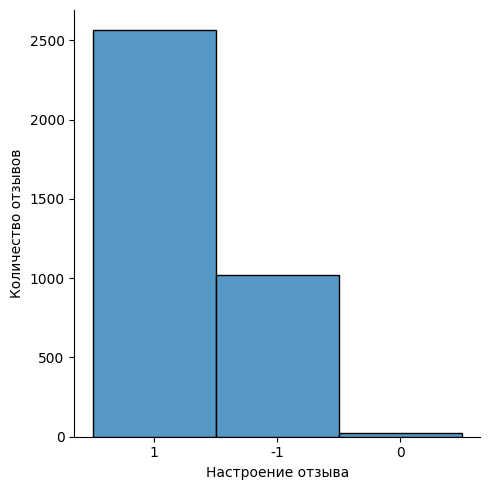

In [195]:
import seaborn as sns
sns.displot(df.sentiment1.astype(str))
plt.xlabel('Настроение отзыва')
plt.ylabel('Количество отзывов')
plt.show()

# Выводы

Подводя итог анализа, можно сказать, что более 70% отзывов о авиакомпании British Airways являются положительными.

Первый отзыв был написан в 2011 году, значит авиакомпания в среднем получает около 300 письменных отзывов за год.

Большинство отзывов про кресла, питание, команду авиакомпании и время полета.

Цель исследования выполнена, однако, и с этими данными можно еще поработать :)